# Final Exercise
This is the final exercise in our Into to Machine Learning Course.\
207027053 - Gil Yair Yamin

First thing we need to do is of course import all libraries we will be using:

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

Let's read the data from the csv file we were given.

In [20]:
raw_data = pd.read_csv("cancer_data.csv", header=None)

We must normalize the data before we continue:

In [21]:
def normalize(mat):
    mean = np.mean(mat, axis=0)
    std_deviation = np.std(mat, axis=0)
    return (mat - mean) / std_deviation

normalized_data = normalize(raw_data)

Now we'll create the matrix X, and vector y.

In [22]:
ones = np.ones((normalized_data.shape[0], 1), dtype=np.float64)

X = np.concatenate((ones, normalized_data.iloc[:, :-1]), axis=1, dtype=np.float64)
y = normalized_data.iloc[:, -1]

Let's define a function that recieves the vector $\Theta$ and a vector $x$, and returns the result of $h_\Theta(x)$\
We are assuming that $x[0] = 1$.

In [23]:
def calc_h_theta(theta: np.ndarray, x: np.ndarray):
    return theta.dot(x)

Let's define a function that recieves a vector $\Theta$, the matrix $X$, and the vector $y$, and returns the value of $J(\Theta)$.

In [24]:
def calc_MSE(theta: np.ndarray, X: np.ndarray, y: np.ndarray):
    m = len(y)
    H = X.dot(theta)
    norm = np.linalg.norm(H - y)

    return np.square(norm) / (2 * m)

Let's define a function that recieves a vector $\Theta$, the matrix $X$, and the vector $y$, and returns the value of $\triangledown J(\Theta)$.

In [25]:
def calc_Gradient(theta: np.ndarray, X: np.ndarray, y: np.ndarray):
    m = len(y)
    XT = X.transpose()
    H = X.dot(theta)

    return XT.dot(H - y) / m

Let's write the Gradient Decent function here.\
We must recieve the data, including X and y, and we also must recieve parameters for our 3 ending conditions:
$$||\Theta^{(k + 1)} - \Theta^{(k)}|| < \epsilon$$
$$|J(\Theta^{(k + 1)}) - J(\Theta^{(k)}))| < \delta $$
$$k + 1 < M $$

Notice, I created default values for $M$, $\delta$ and $\epsilon$.\
They can be changed when calling the function, but I decided it would be best to leave them like this.

In [26]:
# Originally seperated all of these constants between cell blocks

MAX_ITERATIONS = 20
EPSILON = 1e-6
DELTA = EPSILON
BATCH_SIZE = 64

alpha_arr = np.array([0.1, 0.05, 0.01, 0.005, 0.001])

In [27]:
def gradient_decent(
    X, y, alpha, M=MAX_ITERATIONS, epsilon=EPSILON, delta=DELTA
):
    thetaK = np.zeros((X.shape[1]))
    thetaKPlus1 = thetaK
    J = [calc_MSE(thetaK, X, y)]

    for _ in range(M):
        thetaKPlus1 = thetaK - calc_Gradient(thetaK, X, y) * alpha
        J.append(calc_MSE(thetaKPlus1, X, y))

        if np.linalg.norm(thetaKPlus1 - thetaK) < epsilon:
            break

        if J[-1] == np.inf or np.abs(J[-1] - J[-2]) < delta:
            break

        thetaK = thetaKPlus1

    return thetaKPlus1, J

Let's create the batchGradientDecent function:

In [28]:
def batch_gradient_decent(
    X,
    y,
    alpha,
    M=2000,
    epsilon=EPSILON,
    delta=DELTA,
    b_size=BATCH_SIZE,
):

    length = len(X)
    # Originally made a mistake using "np.linspace(0, length, b_size, dtype=int)"
    cell_size = length // b_size + 1
    indexes = np.linspace(0, length, cell_size, dtype=int)

    amount = len(indexes) - 1

    x_batch = [X[indexes[i] : indexes[i + 1]] for i in range(amount)]
    y_batch = [y[indexes[i] : indexes[i + 1]] for i in range(amount)]

    thetaK = np.zeros((X.shape[1]))
    thetaKPlus1 = thetaK

    J = [calc_MSE(thetaK, x_batch[0], y_batch[0])]
    for k in range(M):
        Xb = x_batch[k % amount]
        yb = y_batch[k % amount]

        thetaKPlus1 = thetaK - calc_Gradient(thetaK, Xb, yb) * alpha
        if k % amount:
            J.append(calc_MSE(thetaKPlus1, X, y))
            if J[-1] == np.inf or np.abs(J[-1] - J[-2]) < delta:
                break

        if np.linalg.norm(thetaKPlus1 - thetaK) < epsilon:
            break

        thetaK = thetaKPlus1

    return thetaKPlus1, J

Here I write a function that will generate the matplotlib figure in order to draw the result.

In [29]:
def create_iteration_graph(alpha_arr, data, title="default"):
    df = pd.DataFrame(data)
    df.set_index(alpha_arr, inplace=True)
    df = df.transpose()

    labels = []
    for alpha in alpha_arr:
        labels.append(f"alpha={alpha}")

    fig = plt.figure()
    ax1 = fig.add_axes([0, 0, 2, 1])
    ax1.plot(df, label=labels)
    ax1.set_title(title)
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("$J(\\theta)$", rotation=0, labelpad=20)
    ax1.legend(loc=0)
    return fig

In [30]:
def create_time_graph(alpha_arr, time_amounts, title='default'):
    fig = plt.figure()
    ax1 = fig.add_axes([0, 0, 1, 1])
    alpha_str = [str(a) for a in alpha_arr]
    ax1.bar(alpha_str, time_amounts)
    ax1.set_title(title)
    ax1.set_xlabel("Alpha")
    ax1.set_ylabel("Time in seconds", rotation=0, labelpad=20)

    return fig

Let's test our Gradient_Decent function:

In [31]:
def run_gradient_decent(X, y, alpha_arr, gradient_func, title):
    thetaK = []
    J_History = []
    time_amount = []

    for i in range(alpha_arr.shape[0]):
        start = time.time()
        theta, J = gradient_func(X, y, alpha=alpha_arr[i])
        end = time.time()
        time_amount.append(end - start)
        thetaK.append(theta)
        J_History.append(J)

    create_iteration_graph(alpha_arr, J_History, f"{title} iterations")
    create_time_graph(alpha_arr, time_amount, f"{title} time")

Let's run our regular gradient decent.

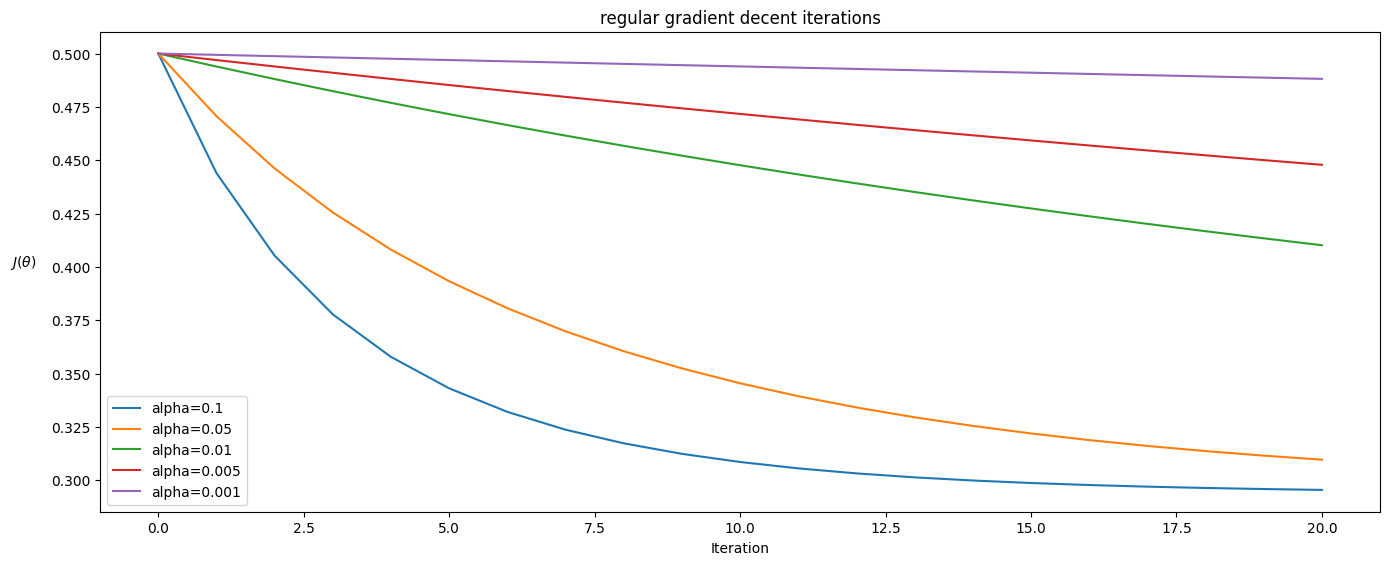

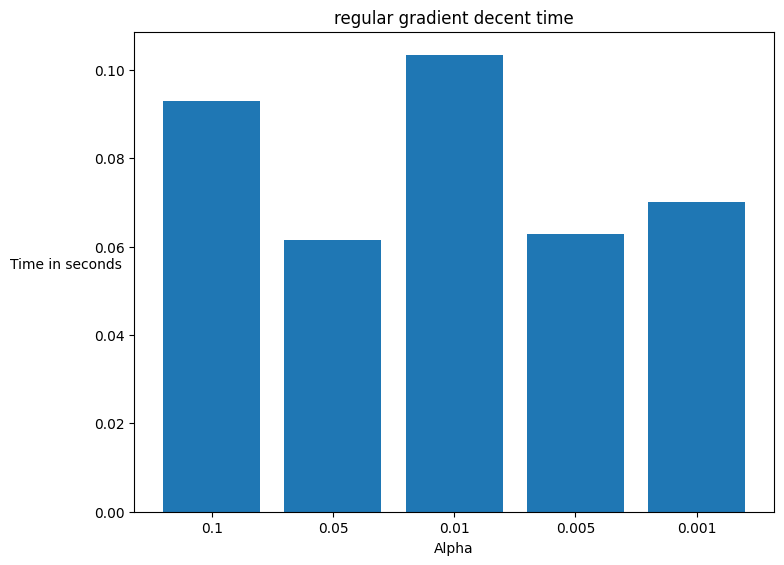

In [32]:
run_gradient_decent(X, y, alpha_arr, gradient_decent, "regular gradient decent")

As we can see above.
1. $J(\theta)$ is getting smaller the more iterations we make.
2. Generally speaking, the bigger alpha is the more iterations (and time) it needs to converge.
3. When $J(\theta)$ sometimes converges before reaching M iterations, and we can see the line breaking before the end of the graph.

Let's run our batch gradient decent function:

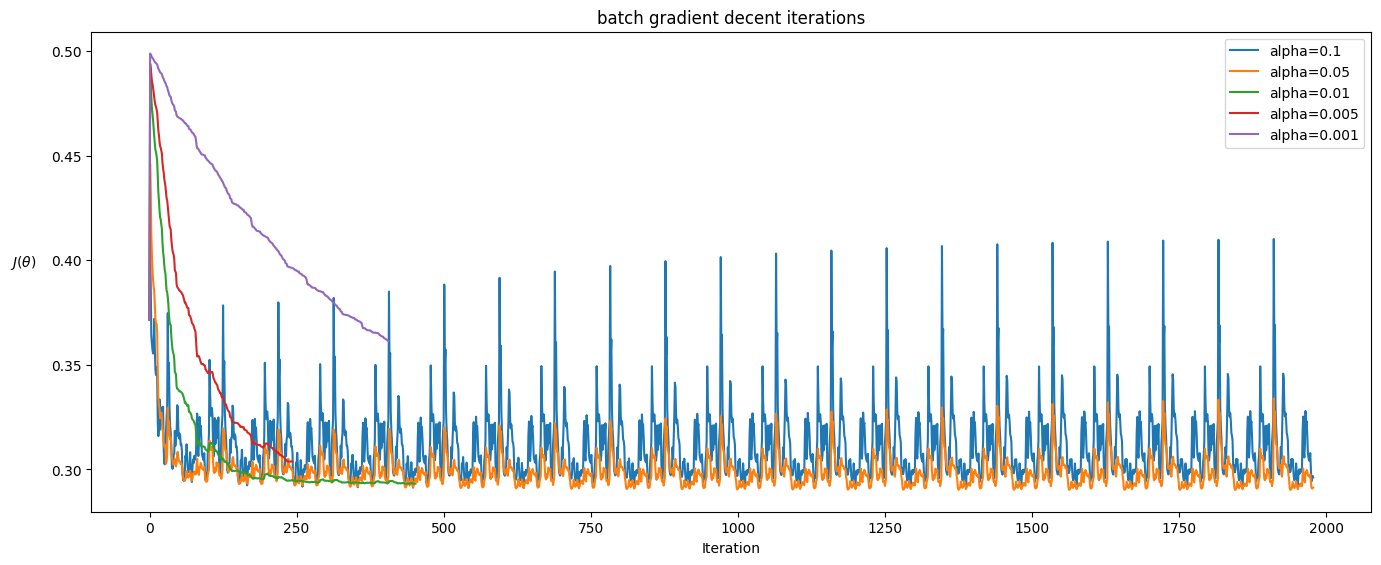

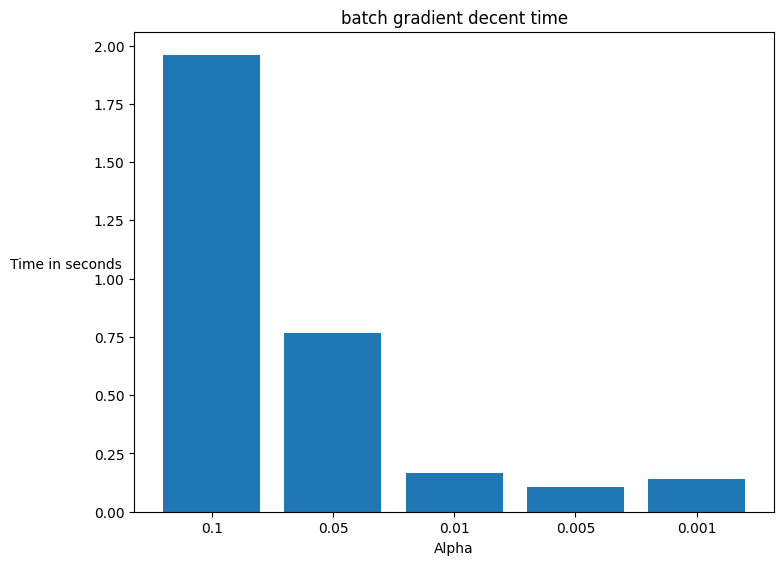

In [33]:
run_gradient_decent(X, y, alpha_arr, batch_gradient_decent, "batch gradient decent")

Conclusions:
1. The line is less smooth than our normal gradient decent, meaning that changes are not uniform.
2. It seems that it took about the same amount of iterations to converge, but since we are using batch gradient decent, it means we went over much less data, meaning we converged on a theta after going over less data.
3. When $\alpha=0.1$ it seems the answer never converges, so even with batch gradient decent we need to be careful about what we choose as our $\alpha$
4. The time it took for every $\alpha$ to converge is shorter than the normal gradient decent.


Let us do an SVD reduction:

In [34]:
dim = 3

U, s, Vt = np.linalg.svd(normalized_data.iloc[:, :-1], full_matrices=True)
reduced_data = U[:, :dim].dot(np.diag(s[:dim]))
mormalized_reduced_data = normalize(reduced_data)
reduced_X = np.concatenate((ones, mormalized_reduced_data), axis=1, dtype=np.float64)

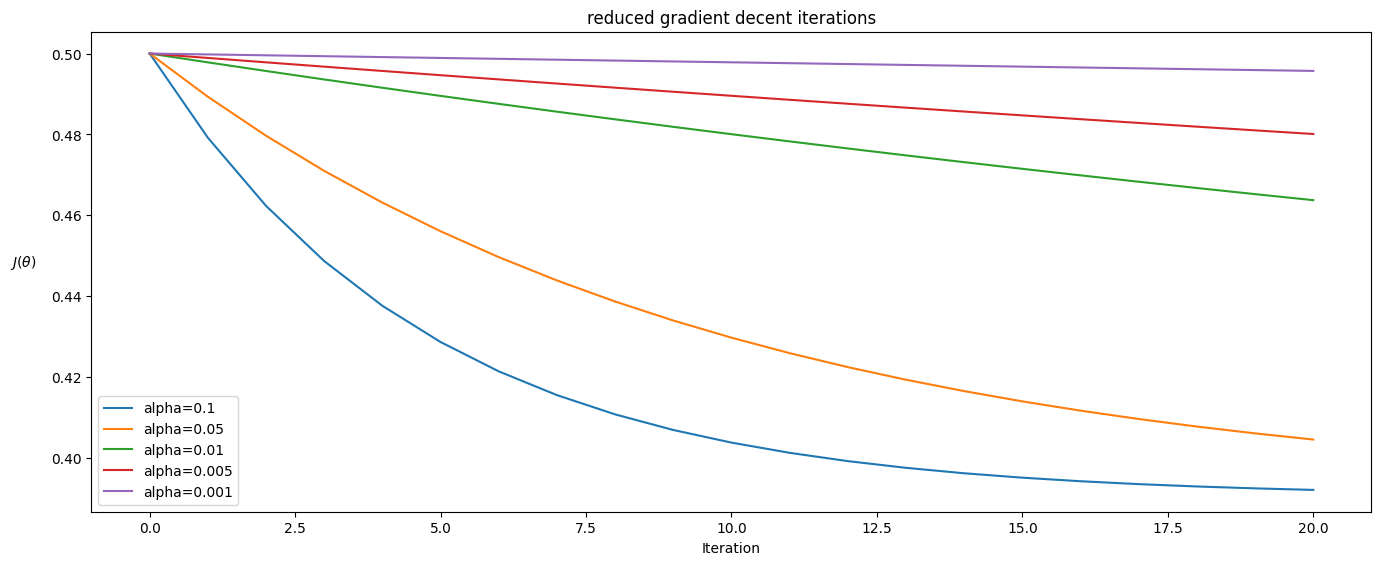

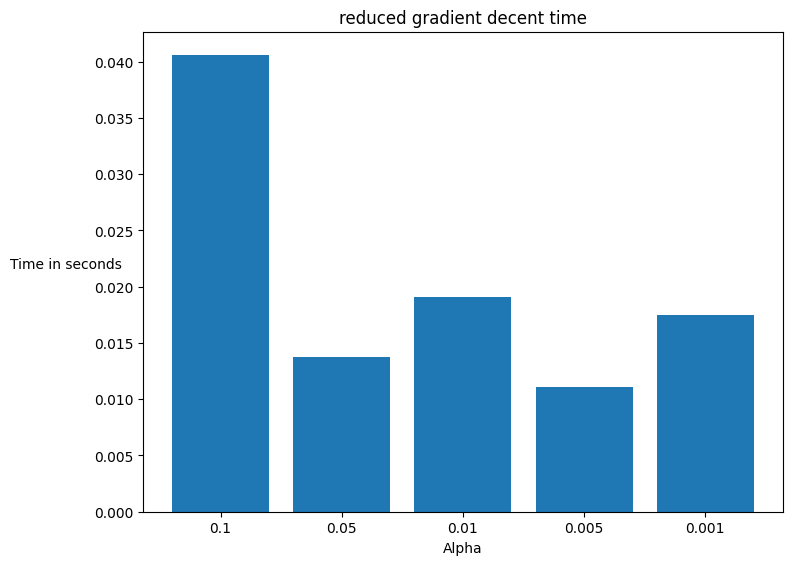

In [35]:
run_gradient_decent(reduced_X, y, alpha_arr, gradient_decent, "reduced gradient decent")

Conclusions:
1. Seems faster than normal gradient decent.
2. Converges after less iterations.

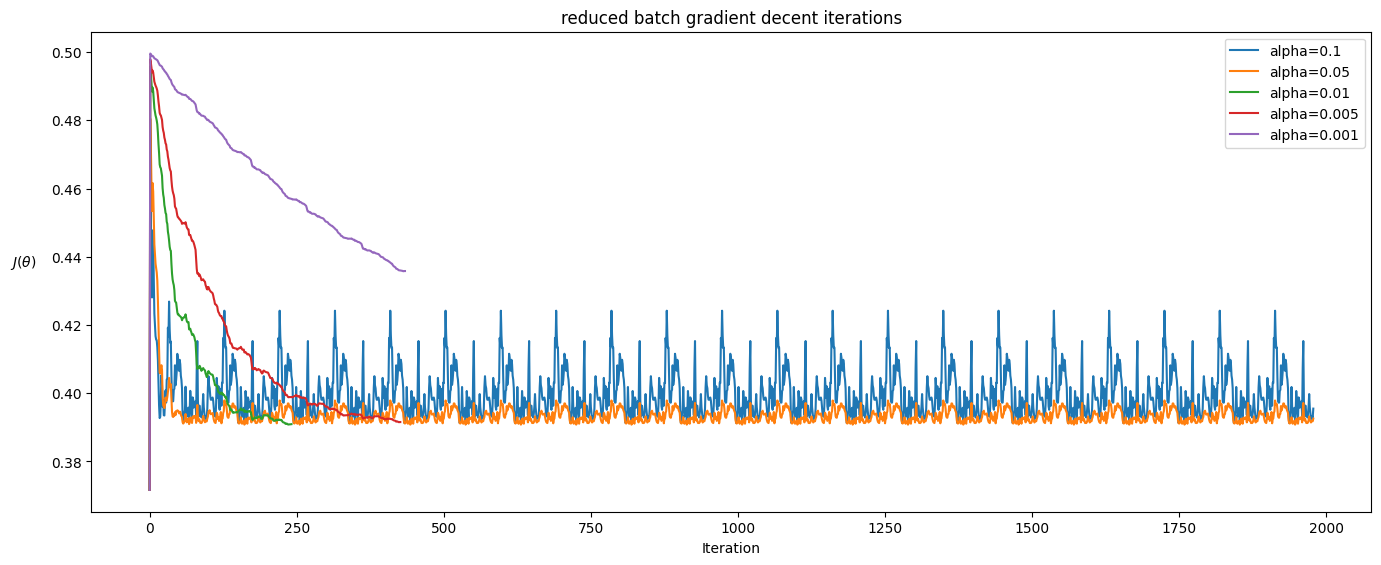

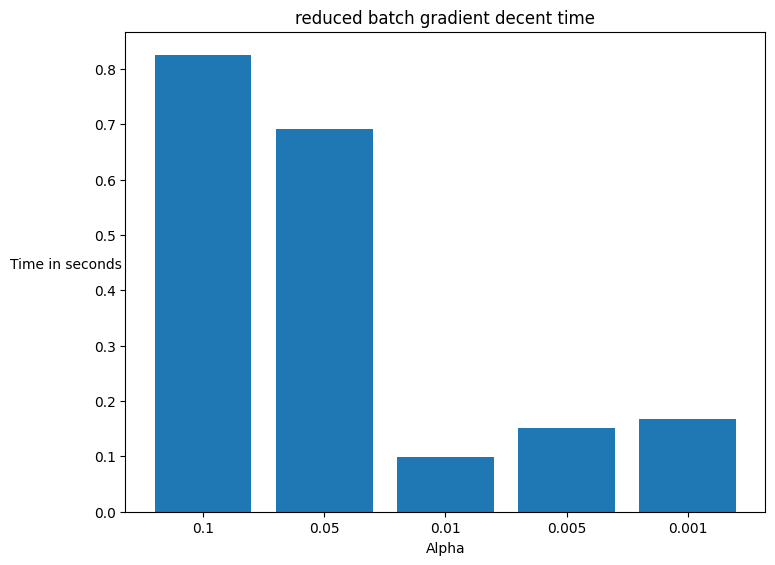

In [36]:
run_gradient_decent(reduced_X, y, alpha_arr, batch_gradient_decent, "reduced batch gradient decent")

Conclusions:
1. Some values of alpha never converged.
2. Alpha is too small, it seems we reached an ending condition too fast, leaving us with a relatively high cost..

Final conclusions:

The normal Gradient Decent algorithm seems to work fine on a dataset that is not too large, such as the one in our example.\
However it seems that in larger datasets, more accurate $\epsilon$ and $\delta$ values, or larger number of iterations can make this algorithm unusable.

The mini-batch improvement seems very significant in converging time.\
However, since we are using a small sample of data in every iteration, we do lose a bit of our accuracy.\
Furthermore, it seems that our range of usable $\alpha$ values is smaller, since $\alpha$ values that converged using our regular gradient decent algorithm did not converge in our mini-batch algorithm.\
When using mini-batch we need to take that into account if we want a viable result.

Reducing the dataset's features seems to also significantly improve the learning time.\
But reducing features also comes with the risk of not considering all of the important factors.

Using our batch algorithm on our reduced data-set seemed to be the least stable and reliable solution.\
When $\alpha$ was in a workable range, the algorithm convereged very fast.\
But the workable $\alpha$ value range became even smaller than before.